In [1]:
from ipywidgets.widgets import interact
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np

# Morris-Lecar model



In [2]:
# Morris-Lecar parameters for steady-state functions
V_1, V_2, V_3, V_4 = -1.2, 18.0, 2.0, 30.0  # [mV]
phi = 0.04

In [3]:
# Morris-Lecar steady-state functions
def m_inf(V):
    return 0.5 * (1 + np.tanh((V - V_1) / V_2))

def w_inf(V):
    return 0.5 * (1 + np.tanh((V - V_3) / V_4))

def tau_w(V):
    return 1.0 / np.cosh((V - V_3) / (2 * V_4))

In [4]:
def default_pars(**kwargs):
    """
    Fix the dictionary of parameters of Morris-Lecar model.
    """
    pars={}
    pars['C_m'] = 5.0     # Membrane capacitance [mF]
    pars['g_Ca'] = 4.0    # Calcium conductance [mS]
    pars['g_K'] = 8.0     # Potassium conductance [mS]
    pars['g_L'] = 2.0     # Leak conductance [mS]
    pars['V_Ca'] = 120.0  # Calcium reversal potential [mV]
    pars['V_K'] = -80     # Potassium reversal potential [mV]
    pars['V_L'] = -60     # Leak reversal potential [mV]
    pars['I_ext'] = 80    # Entry current [mA]

    return pars

In [5]:
# Morris-Lecar model
def morris_lecar(x, t, params):
    """
    Compute Morris-Lecar model based on the previous state of V and w.
    """
    V, w = x
    dV_dt = (params['I_ext'] - params['g_Ca'] * m_inf(V) * (V - params['V_Ca']) \
             - params['g_K'] * w * (V - params['V_K']) \
             - params['g_L'] * (V - params['V_L'])) / params['C_m']
    dw_dt =  phi * ((w_inf(V) - w) / tau_w(V))
    return [dV_dt, dw_dt]

In [6]:
def solve_system(t, params, initial_conditions):
    """
    Find the numerical solution for the evolution over time of the state variables V and w.
    """
    x = odeint(morris_lecar, initial_conditions, t, args=(params,))
    V, w = x.T
    return V, w

## Nullclines


In [7]:
# Nullcline equations
def get_nullclines(params):
    """
    Compute nullclines for v and w.
    """
    v = np.linspace(-60,60,100)
    v_n = (params['I_ext'] - (params['g_Ca'] * m_inf(v) * (v - params['V_Ca'])) \
           - (params['g_L'] * (v - params['V_L']))) / (params['g_K'] * (v - params['V_K']))

    w_n = w_inf(v)
    return v, v_n, w_n

# Taken from https://www.researchgate.net/publication/295672877_An_electronic_implementation_for_Morris-Lecar_neuron_model

In [8]:
# Vector field equations (to display the arrows)
def plot_vector_field(plt, params):
    """
    Compute vector field for the nullcline plot.
    """
    V_values = np.linspace(-60, 60, 35)
    w_values = np.linspace(-0.1, 1, 80)
    V_grid, w_grid = np.meshgrid(V_values, w_values)

    # Initialize arrays to store vector field components
    dV_dt_grid = np.zeros_like(V_grid)
    dw_dt_grid = np.zeros_like(w_grid)

    # Calculate vector field components at each point in the grid
    for i in range(len(V_values)):
        for j in range(len(w_values)):
            dV_dt_grid[j, i], dw_dt_grid[j, i] = morris_lecar([V_values[i], w_values[j]], 0, params)

    # Normalize the vectors to ensure consistent arrow lengths
    magnitude = np.sqrt(dV_dt_grid**2 + dw_dt_grid**2)
    dV_dt_grid /= magnitude*2
    dw_dt_grid /= magnitude*2

    # Plot the vector field
    plt.quiver(V_grid, w_grid, dV_dt_grid, dw_dt_grid, scale=25, color='grey', width=0.002)

In [9]:
def plot_simulation(t, V, w, params):
    # Plot the phase plane trajectory, with nullclines and vector field
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)

    # Plot nullclines
    v_values = np.linspace(-60, 60, 100)

    plt.xlabel('Membrane Potential (mV)')
    plt.ylabel('Recovery Variable (w)')
    plt.title('Morris-Lecar Phase Plane with Nullclines and Vector Field')

    nullclines = get_nullclines(params)
    plt.plot(nullclines[0], nullclines[2], label='w nullcline', color='r')
    plt.plot(nullclines[0], nullclines[1], label='V nullcline', color='b')
    plt.plot(V, w, label='Trajectory', color="black")

    plot_vector_field(plt, params)
    plt.legend()
    plt.ylim(-0.1, 0.7)
    plt.grid(True)

    # Plot output current
    plt.subplot(1, 2, 2)
    plt.title('Timeseries for for time-dependent $I_{ext}$')

    plt.plot(t, V, label='v(t)')
    plt.plot(t, w, label='w(t)')

    plt.xlabel('Time (t)')
    plt.ylabel('State variables')
    plt.legend()
    plt.grid(True)
    plt.show()

## Test configurations


In [10]:
# Define simulation configuration

t_span = (0, 1000)                            # Simulation time of 1000 ms
t = np.linspace(t_span[0], t_span[1], 10000)  # Linearly spaced time points

### Scenario 1: No spiking activity

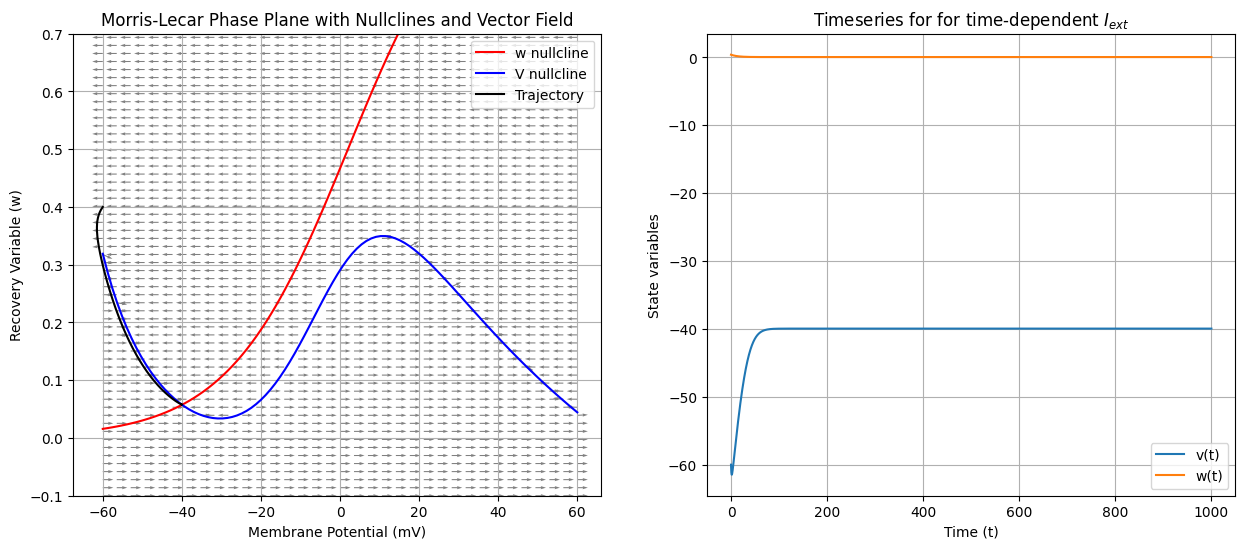

In [11]:
# Define the model parameters
params = default_pars()
params['I_ext'] = 50

# Define the initial conditions
initial_conditions = [-60, 0.4]

# Solve the system and extract the states
V, w = solve_system(t, params, initial_conditions)

# Plot the results
plot_simulation(t, V, w, params)

## Scenario 2: Sub-threshold oscillations

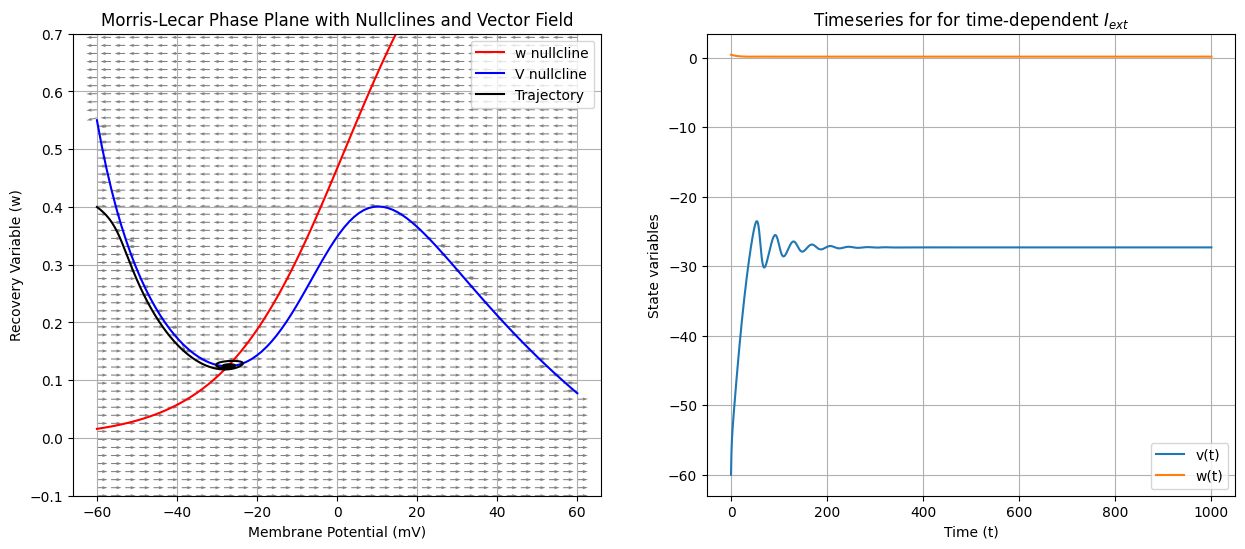

In [12]:
# Define the model parameters
params = default_pars()
params['I_ext'] = 87

# Define the initial conditions
initial_conditions = [-60, 0.4]

# Solve the system and extract the states
V, w = solve_system(t, params, initial_conditions)

# Plot the results
plot_simulation(t, V, w, params)

## Scenario 3: Tonic spiking

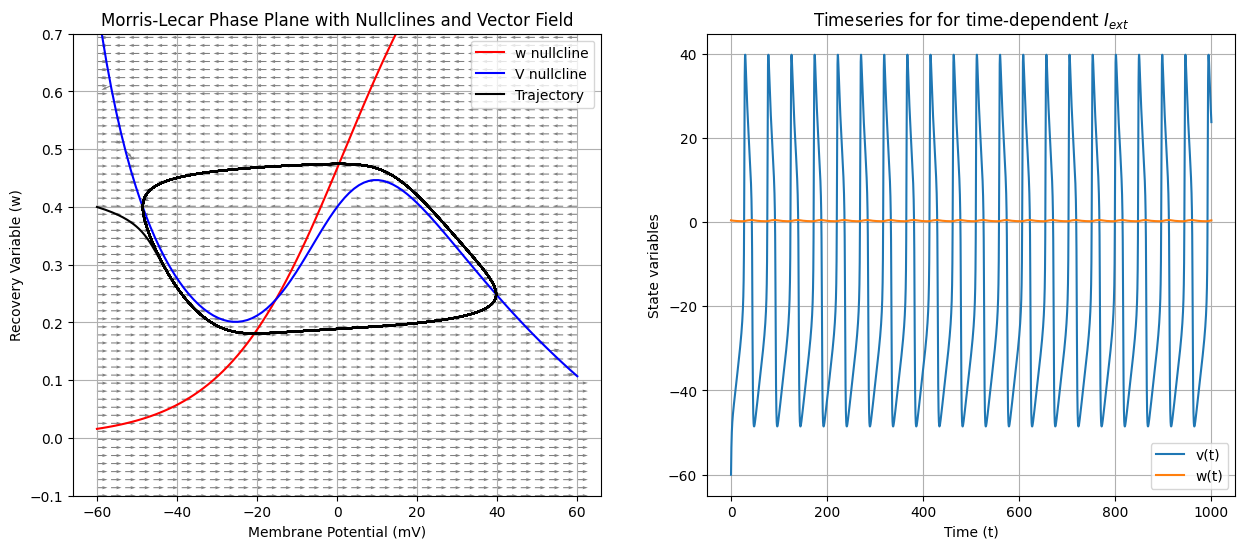

In [13]:
# Define the model parameters
params = default_pars()
params['I_ext'] = 120

# Define the initial conditions
initial_conditions = [-60, 0.4]

# Solve the system and extract the states
V, w = solve_system(t, params, initial_conditions)

# Plot the results
plot_simulation(t, V, w, params)

## Scenario 4: Saturation

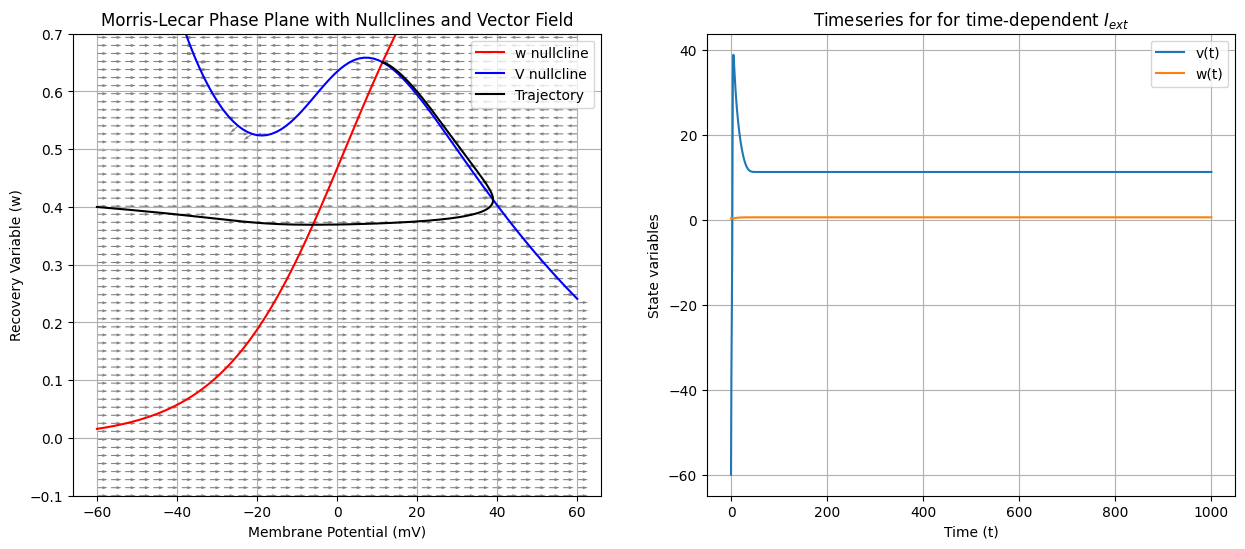

In [14]:
# Define the model parameters
params = default_pars()
params['I_ext'] = 270

# Define the initial conditions
initial_conditions = [-60, 0.4]

# Solve the system and extract the states
V, w = solve_system(t, params, initial_conditions)

# Plot the results
plot_simulation(t, V, w, params)

# Interactive plot

In [15]:
def interactive_plot(V0, w0, I_ext):
    """
    Plot trajectories for different initial conditions and different I_ext.
    """
    # Define the model parameters
    params = default_pars()
    params['I_ext'] = I_ext

    # Define the initial conditions
    initial_conditions = [V0, w0]

    # Solve the system and extract the states
    V, w = solve_system(t, params, initial_conditions)

    # Plot the results
    plot_simulation(t, V, w, params)

In [16]:
_ = interact(interactive_plot, V0=(-60, 60, .2), w0=(-0.1, 0.7, 0.01), I_ext=(0, 300, 0.1))

interactive(children=(FloatSlider(value=0.0, description='V0', max=60.0, min=-60.0, step=0.2), FloatSlider(val…